Written by Matt Mortimer, started 28 Sep 2021,
matthew.mortimer@anu.edu.au,
Orcid ID: https://orcid.org/0000-0002-8135-9319
Python 3

# Overview
*Background:* Engineer plant nitrate reductase enzyme into perchlorate reductase  
*Aim:* Phylogenetic component of the project aims to generate a plant nitrate reductase enzyme phlyogeny and reconstruct the ancestors  
*Data sources:* 
    Primary - One Thousand Plant Transcriptome TBlastN (default settings), 10k sequences  
                210719_NR_1kp.fasta  
                210719_NR_1kp_details.txt  
            - Phytozome, TBLASTN (e-value threshold -10, word length default, BLOSUM62, allow gaps) 848 sequences 
                211021_NR_phyto_details.txt 
     Secondary - Download of PF00384 family (may not use), 31166 sequences  
                PF00384_full_w_nitrate_reductase.txt  

In [1]:
from Bio import SeqIO
from Bio import Entrez

Entrez.email = 'matthew.mortimer@anu.edu.au'

from random import shuffle
from random import seed

import pandas as pd
import seaborn as sns 
import os as os
import re
import sys

from modules.annotations import *
from modules.cleaner import *
from modules.analysis import len_distro
from modules.run_blast import blast
from modules.size_filter import *
from modules.utilities import *
from modules.motif_finder import *

from datetime import datetime
DATE = datetime.now().strftime('%y%m%d')

# Nitrate Reductase data processing

# Phytozome processing

In [2]:
# Take the phytozome BLASTP output 
# Add results to the cart, then download with 'Attributes' -> 'Header Information', selection
# 'Gene Name' + 'Organism Name'

# This code will create a csv index file of the sequences and taxonomic info
# Will also generate psudo-Scaffold_ids to match the 1KP dataset

file_n = 'source_data/220818_phyto_nr.fasta'

with open(file_n) as seqs:
    count = 0
    for line in seqs:
        if line.startswith(">"):
            count += 1


# generates the range of unique numbers between 
ids = [i for i in range(1_000_000, 10_000_000)]

# seed to provide reproducibility of shuffle, then shuffles

seed(1)
shuffle(ids)
id_lst = ids[:count]

with open(f'output/220825_phyto_nr_details.txt', 'w+') as ofile:

    ofile.write('Scaffold_id' + '\t' + 'Protein' + '\t' + 'Short_species' + '\t' + 'Phyto_species' +' \t' +  'Sequence' '\n')
    for seq_record in SeqIO.parse(f'source_data/220818_phyto_nr.fasta', 'fasta'):
        count += 1
        sequence = str(seq_record.seq).upper() # Converts sequence to uppercase string
        sequence = sequence.rstrip("*")
        h = seq_record.id.lstrip('>').split('|')
        h1 = h[0]
        h2 = h[1].split('_')[0]
        h3 = h2[0]
        h4 = h2[1:]
        species = h3 + '_' + h4
        scaf = id_lst.pop()

        ofile.write('PHYT_' + str(scaf) + '\t' + h1 + '\t' + species + '\t' + h[1] + '\t' + sequence + '\n')

# Manually correct with full species names, file named 'output/220825_phyto_nr_details_curated.csv'

In [4]:
# Formats the above manually curated csv into one with only relevant fields

phyto_index = pd.read_csv('output/220825_phyto_nr_master_index_curated.csv', sep="\t")
tax_data = pd.read_csv('source_data/220825_species_taxonomy.csv')
tax = tax_data[['Species', 'Description', 'Order']]
phyto_master_index = pd.merge(phyto_index, tax, how = 'left', left_on = 'Short_species', right_on = "Species")

phyto_master_index.drop('Short_species', axis=1, inplace=True)

phyto_master_index.to_csv(f'output/220825_phyto_nr_master_index.csv', index = False)

In [6]:
phyto_df = pd.read_csv(f'output/220825_phyto_nr_master_index.csv', sep = ',')

phyto_df2 = phyto_df

phyto_df2['Header'] = phyto_df['Scaffold_id'] + '|' + phyto_df['Species'] + '|' + phyto_df['Description']+ '|' + phyto_df['Order']

phyto_dict = dict(zip(phyto_df2['Header'], phyto_df2['Sequence']))

with open(f'output/220826_phyto_nr_seq_cleaning.fasta', 'w') as form: # Creates a fasta file with informative header
                                                                # for use going forward
    for k,v in phyto_dict.items(): 
        form.write(f'>{k}\n{v}\n')

print(f'Number of sequences in output/220826_phyto_nr_seq_cleaning.fasta: {len(phyto_dict)}')

Number of sequences in output/220826_phyto_nr_seq_cleaning.fasta: 3859


In [7]:
cleaner('output/220826_phyto_nr_seq_cleaning.fasta', 'phyto')

3560 were kept, output was written to 220826_phyto_cleaned.fasta. 214 sequences were dropped and written to output/220826_phyto_cleaner_dropped_seq.fasta
There were 299 instances of duplicate or ambiguous sequences.
output/220826_phyto_cleaned.fasta


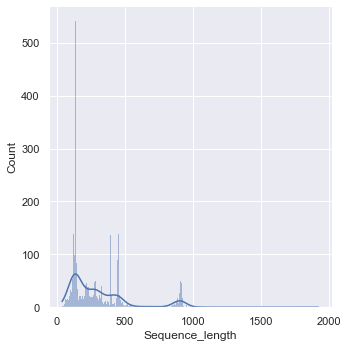

In [8]:
len_distro(f'output/{DATE}_phyto_cleaned.fasta')

In [9]:
size_filter(f'output/{DATE}_phyto_cleaned.fasta', 'phyto', 'greater', 700)

Seqeunces from output/220826_phyto_cleaned.fasta were filtered to those greater than 700 aa
335 filtered sequences were outputed to "output/220826_phyto_size_filt.fasta"


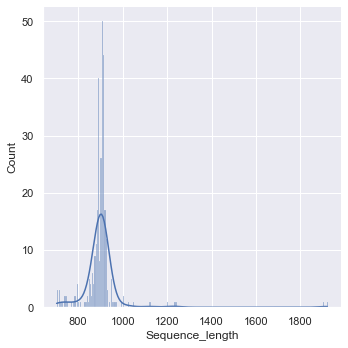

In [11]:
len_distro(f'output/220826_phyto_size_filt.fasta')

[('MA', 248), ('MG', 17), ('MT', 15), ('MS', 14), ('ME', 7), ('MD', 5), ('ML', 4), ('MH', 4), ('MP', 3), ('MV', 3)]
The most common aa at n-terminal is "MA" and its freq. is: 
0.740


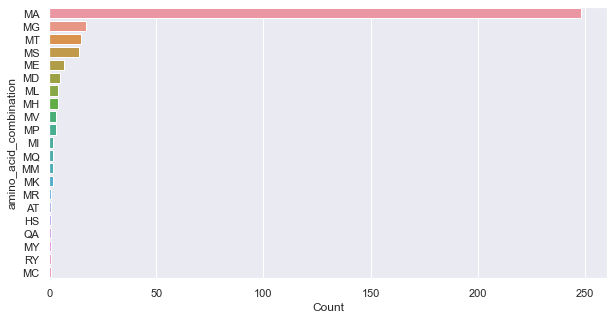

In [12]:
chart(f'output/220826_phyto_size_filt.fasta', 2, 'n', 10, 5)

[('VF', 145), ('IF', 95), ('SF', 21), ('LF', 14), ('EF', 12), ('QF', 12), ('TF', 4), ('LY', 2), ('RY', 2), ('VD', 2)]
The most common aa at c-terminal is "VF" and its freq. is: 
0.433


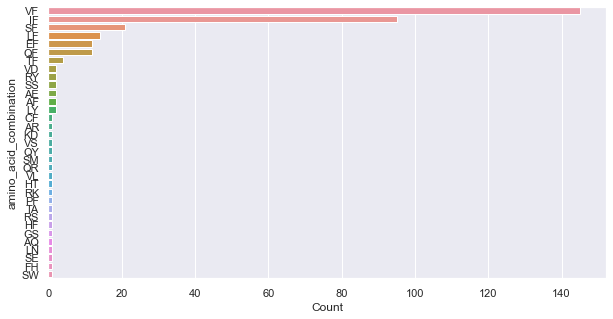

In [13]:
chart(f'output/220826_phyto_size_filt.fasta', 2, 'c', 10, 5)

In [ ]:
#terminal_filter(f'output/220323_phyto_size_filt.fasta', 'phyto', 'n', 'M')

In [ ]:
#terminal_filter(f'output/220323_NR_phyto_n-terminalCodon.fasta', 'phyto', 'c', 'F', 'Y', 'L')

In [ ]:
#chart(f'output/220323_NR_phyto_c-terminalCodon.fasta', 1, 'c', 10, 5)

# 1kp processing

In [9]:
# # Format details file, create master index
# details = pd.read_csv('source_data/211014_NR_1kp_details_formatted.csv', sep = ',')
# species_1kp = pd.read_csv('source_data/211020_species_taxonomy.csv', sep = ',')
# NR_1kp_index = pd.merge(details, species_1kp, how = 'inner', on='Onekp_index_id') # Merges dataframes
# NR_1kp_index['Scaffold_id'] = NR_1kp_index['Onekp_index_id'] + '_' + NR_1kp_index['Seq_id'].astype(str) # Creates a new column

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []

for seq_record in SeqIO.parse('source_data/220818_1kp_nr.fasta', 'fasta'):
    sequence = str(seq_record.seq).upper() # Converts sequence to uppercase string
    header = seq_record.id
    species = seq_record.description.split(' ')[1]
    head_split = header.split('|')
    h = head_split[2]
    h2 = h.split('_')
    h3 = h2[0]
    h4 = h2[2]

    onekp_index_id = h3
    seq_id = h4
    scaffold_id = h3 + '_' + h4

    l1.append(scaffold_id)
    l2.append(h3)
    l3.append(h4)
    l4.append(sequence)
    l5.append(species)
    l6.append(header)


scaffold_df = pd.DataFrame(list(zip(l6, l1, l2, l3, l4, l5)),
               columns =['Subject Seq-id', 'Scaffold_id', 'Onekp_index_id', 'seq_id', 'Sequence', 'Subject Scientific Name'])

### Creating the species-order-phylum-taxId reference was interative and require curating. The cells belows cannot be run sequentially. 

In [10]:
details_df = pd.read_csv('source_data/220818_1kp_nr_details.csv', sep = '\t')

onekp_temp_df = pd.merge(scaffold_df, details_df, how = 'left', on = 'Subject Seq-id')

In [5]:
id_lst = onekp_temp_df['Subject Taxonomy ID'].to_list()

In [6]:
len(id_lst)

10098

In [11]:
tax_data = pd.read_csv('source_data/220825_species_taxonomy.csv')
tax = tax_data[['Onekp_index_id', 'Species', 'Description', 'Order']]
onekp_df = pd.merge(onekp_temp_df, tax, how = 'left', on = 'Onekp_index_id')

In [12]:
onekp_df

,Subject Seq-id,Scaffold_id,Onekp_index_id,seq_id,Sequence,Subject Scientific Name_x,Query accesion,Subject Scientific Name_y,Subject Taxonomy ID,Percentage of identical matches,...,Start of alignment in query,End of alignment in query,Start of alignment in subject,End of alignment in subject,Total number of gap,Expect value,Bit score,Species,Description,Order
0,gnl|onekp|DLJZ_scaffold_2059039,DLJZ_2059039,DLJZ,2059039,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSSKHELP...,Solanum_ptychanthum,BLAST_AUTO_ID_1,Solanum ptychanthum,45838,97.149,...,1,911,1,912,1,0.000000e+00,1854.0,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales
1,gnl|onekp|GHLP_scaffold_2060647,GHLP_2060647,GHLP,2060647,MAASVENRQFSHLEPGLSGVGRTNFKPRSDSPVRGCNFPSSNHELP...,Solanum_dulcamara,BLAST_AUTO_ID_1,Solanum dulcamara,45834,96.711,...,1,911,1,911,2,0.000000e+00,1841.0,Solanum_dulcamara,Core_eudicots/Asterids,Solanales
2,gnl|onekp|NMDZ_scaffold_2097332,NMDZ_2097332,NMDZ,2097332,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNQELPF...,Solanum_sisymbriifolium,BLAST_AUTO_ID_1,Solanum sisymbriifolium,205582,94.951,...,1,911,1,910,1,0.000000e+00,1778.0,Solanum_sisymbriifolium,Core_eudicots/Asterids,Solanales
3,gnl|onekp|UGJI_scaffold_2005747,UGJI_2005747,UGJI,2005747,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNHELPF...,Lycopersicon_cheesmanii,BLAST_AUTO_ID_1,Solanum cheesmaniae,142759,95.280,...,1,911,1,907,4,0.000000e+00,1777.0,Lycopersicon_cheesmanii,Core_eudicots/Asterids,Solanales
4,gnl|onekp|AIOU_scaffold_2071582,AIOU_2071582,AIOU,2071582,MAASVENRQFSHLEPGLSGVGRSFKPRSDSPVRGCNFPPPNHELGF...,Brugmansia_sanguinea,BLAST_AUTO_ID_1,Brugmansia sanguinea,540794,95.060,...,1,911,1,910,1,0.000000e+00,1768.0,Brugmansia_sanguinea,Core_eudicots/Asterids,Solanales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10093,gnl|onekp|JUWL_scaffold_2007238,JUWL_2007238,JUWL,2007238,AKIYRLEDIAKHNTHEDCWLVIAGKVYDVSRFLEDHPGGDEVLLSA...,Keteleeria_evelyniana,BLAST_AUTO_ID_1,Keteleeria evelyniana,123598,36.842,...,536,610,1,76,1,1.130000e-13,76.3,Keteleeria_evelyniana,Acrogymnospermae,Pinales
10094,gnl|onekp|EDHN_scaffold_2002992,EDHN_2002992,EDHN,2002992,GGDGKLFTLAQVSEHNSPKDCWLIIDGKVYDVTKFLEDHPGGDEVL...,Ficus_religiosa,BLAST_AUTO_ID_1,Ficus religiosa,66387,37.179,...,537,613,5,82,1,1.130000e-13,76.3,Ficus_religiosa,Core_eudicots/Rosids,Rosales
10095,gnl|onekp|VCCF_scaffold_2001085,VCCF_2001085,VCCF,2001085,MGGEGNVYTLSEVSEHNKRKDCWLVIEGQVYDVTKFLDDHPGGDEV...,Melia_azedarach,BLAST_AUTO_ID_1,Melia azedarach,155640,37.500,...,532,610,1,80,1,1.140000e-13,76.3,NaN,NaN,NaN
10096,gnl|onekp|HENI_scaffold_2011029,HENI_2011029,HENI,2011029,MGGDGKVFTLAQVSEHNTNKDCWLIINGKVYDVTKFLEDHPGGDEV...,Quercus_shumardii,BLAST_AUTO_ID_1,Quercus shumardii,262619,35.000,...,532,610,1,80,1,1.140000e-13,76.3,Quercus_shumardii,Core_eudicots/Rosids,Fagales


In [9]:
nas = onekp_df[onekp_df['Species'].isna()]
#nas_taxId = pd.merge(nas, onekp_temp_df, how='left', on='Subject Seq-id')

In [10]:
nas = nas.iloc[:, :18]

In [11]:
nas

,Subject Seq-id,Scaffold_id,Onekp_index_id,seq_id,Sequence,Subject Scientific Name_x,Query accesion,Subject Scientific Name_y,Subject Taxonomy ID,Percentage of identical matches,Alignment length,Number of mismatches,Number of gap openings,Start of alignment in query,End of alignment in query,Start of alignment in subject,End of alignment in subject,Total number of gap
10,gnl|onekp|XKVX_scaffold_2011288,XKVX_2011288,XKVX,2011288,MAASVENRQFSAMEPGLQGMVRALKSRPDSPVRGHFNFQKIPNNVN...,Heliotropium_filiforme,BLAST_AUTO_ID_1,Heliotropium filiforme,1475407,81.967,915,147,6,1,911,1,901,18
11,gnl|onekp|IPPG_scaffold_2060185,IPPG_2060185,IPPG,2060185,MAASVENRQFSAMEPGLQGMVRALKSRPDSPVRGHFNFQKIPNNVN...,Heliotropium_filiforme,BLAST_AUTO_ID_1,Heliotropium filiforme,1475407,81.967,915,147,6,1,911,1,901,18
17,gnl|onekp|UEEN_scaffold_2031822,UEEN_2031822,UEEN,2031822,MAASVENRQFSRISFKPSPAAGHSHHVSDSPVRGCNFPSNSGAEFK...,Forestiera_segregata,BLAST_AUTO_ID_1,Forestiera segregata,126416,80.932,923,148,6,1,911,1,907,28
19,gnl|onekp|TPUT_scaffold_2002459,TPUT_2002459,TPUT,2002459,MAASVENRQFARLEEALTGVVRPYKPGPTTHHRSDSPVRGCNFPQS...,Anthirrhinum_majus,BLAST_AUTO_ID_1,Antirrhinum majus,4151,80.978,920,162,6,1,911,1,916,13
38,gnl|onekp|GAKQ_scaffold_2080464,GAKQ_2080464,GAKQ,2080464,MAASVENRQFSHLEPGLPCVTRPFKPGPTNHHRSGSPVRGCNFPPS...,Schlegelia_parasitica,BLAST_AUTO_ID_1,Schlegelia parasitica,1799629,80.937,918,163,6,1,911,1,913,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10070,gnl|onekp|WSYE_scaffold_2061572,WSYE_2061572,WSYE,2061572,MGSKVLFTLKEVAEHNDPKDCWLIIHGKVYDVTKFLEDHPGGDDVL...,Conzya_canadensis,BLAST_AUTO_ID_1,Erigeron canadensis,72917,32.110,109,70,2,538,642,6,114,4
10071,gnl|onekp|NUSE_scaffold_2060428,NUSE_2060428,NUSE,2060428,MGSKVLFTLKEVAEHNDPKDCWLIIHGKVYDVTKFLEDHPGGDDVL...,Conzya_canadensis,BLAST_AUTO_ID_1,Erigeron canadensis,72917,32.110,109,70,2,538,642,6,114,4
10084,gnl|onekp|GBCQ_scaffold_2016472,GBCQ_2016472,GBCQ,2016472,KMSSDHKVHAFEEVAKHNTKDDCWLIISGKVYNVTSFLDDHPGGDD...,Aerva_persica,BLAST_AUTO_ID_1,Aerva persica,1799555,38.750,80,48,1,532,610,2,81,1
10095,gnl|onekp|VCCF_scaffold_2001085,VCCF_2001085,VCCF,2001085,MGGEGNVYTLSEVSEHNKRKDCWLVIEGQVYDVTKFLDDHPGGDEV...,Melia_azedarach,BLAST_AUTO_ID_1,Melia azedarach,155640,37.500,80,49,1,532,610,1,80,1


In [12]:
na_lst = nas['Subject Taxonomy ID'].to_list()
id_lst = set(na_lst)

## Retrive taxonomic info from NCBI Taxonomy Entrez

In [118]:
# Using Biopython NCBI Entrez utility, query all Subject Taxonomy ID
# in the list and return the taxonomic rankings. Will require manual
# curation

tax_results = {}

# id_lst = [45834, 2801, 41880]

with open("220826_NCBI_nr_taxId.csv", 'w') as doc:
    doc.write('TaxId\tPhylum\tOrder\tClade1\tClade2\tClade3\n')

    for id in id_lst:

        phylum_check = False
        order_check = False
        clade_check = False
        clade = []
        tax_results[str(id)] = {}

        # Query NCBI entrez
        handle = Entrez.efetch(db='taxonomy', id=id, retmode='xml')
        record = Entrez.read(handle, validate=False)
        handle.close()

        # Assign results to dict tax_list
        tax_list = record[0]['LineageEx']

        for tax_element in tax_list:
            # add phylum to dict
            if 'phylum' in tax_element['Rank']:
                if tax_element['Rank'] == 'phylum':
                    tax_results[str(id)]['Phylum'] = tax_element['ScientificName']
                    phylum_check = True
            # add order to dict, if order exists changes order_check to True
            if 'order' in tax_element['Rank']:
                if tax_element['Rank'] == 'order':
                    tax_results[str(id)]['Order'] = tax_element['ScientificName']
                    order_check = True
            # add clades to clade list then adds list to dict, 
            # if order exists changes clade_check to True
            if 'clade' in tax_element['Rank']:
                if tax_element['Rank'] == 'clade':
                    clade.append(tax_element['ScientificName'])
                    tax_results[str(id)]['Clade'] = clade
                    clade_check = True

            # If check False, adds NaN
            if phylum_check is False:
                   tax_results[str(id)]['Phylum'] = 'NaN'            
            if order_check is False:
                   tax_results[str(id)]['Order'] = 'NaN'
            if clade_check is False:
                tax_results[str(id)]['Clade'] = ['NaN']

    # Write tax_results to file            
    for k,v in tax_results.items():
        # Need to assign dict elm to variable so they 
        # can be written to file in the correct order, 
        # not as they appear in the dict
        phylum = ''
        order = ''
        clade_n = []

        for r,d in v.items():
            if r == 'Phylum':
                phylum = d
            if r == 'Order':
                order = d
            if r == 'Clade':
                clade_n = d

        clade_l = len(clade_n)

        doc.write(f'{k}\t')
        doc.write(phylum + '\t')
        doc.write(order + '\t')
        if clade_l >= 3:
            for i in clade_n[-3:]:
                doc.write(i + '\t')
        elif clade_l == 2:
            for i in clade_n:
                doc.write(i + '\t')
            doc.write('NaN')
        elif clade_l == 1:
            doc.write(str(clade_n[0]) + '\t')
            doc.write('NaN\tNaN')

        doc.write('\n')

Need to manually curate the above, turn into csv, then merge with the details_df 

In [13]:
ncbi_tax = pd.read_csv('220826_NCBI_nr_taxId.csv')
ncbi_tax = ncbi_tax[['TaxId', 'Description', 'Order']]
ncbi_tax['TaxId'] = ncbi_tax['TaxId'].astype('int')

In [14]:
ncbi_tax

,TaxId,Description,Order
0,3130,Chlorophyta_algae,Bryopsidales
1,3133,Chlorophyta_algae,Bryopsidales
2,51328,Chlorophyta_algae,Chaetopeltidales
3,56002,Chlorophyta_algae,Chaetopeltidales
4,104536,Chlorophyta_algae,Chaetophorales
...,...,...,...
434,4407,Eudicots,Trochodendrales
435,165298,Core_eudicots/Rosids,Vitales
436,4627,Monocots/Commelinids,Zingiberales
437,94321,Monocots/Commelinids,Zingiberales


In [15]:
tax_updated_df = pd.merge(onekp_df, ncbi_tax, how = 'left', left_on = 'Subject Taxonomy ID', right_on = 'TaxId')
tax_updated_df = tax_updated_df[['Subject Seq-id', 'Scaffold_id', 'Onekp_index_id', 'seq_id', 'Subject Scientific Name_x', 'Subject Taxonomy ID','Sequence']]
tax_updated_df.rename(columns={'Subject Scientific Name_x':'Subject Scientific Name'}, inplace=True)
tax_updated_df

,Subject Seq-id,Scaffold_id,Onekp_index_id,seq_id,Subject Scientific Name,Subject Taxonomy ID,Sequence
0,gnl|onekp|DLJZ_scaffold_2059039,DLJZ_2059039,DLJZ,2059039,Solanum_ptychanthum,45838,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSSKHELP...
1,gnl|onekp|GHLP_scaffold_2060647,GHLP_2060647,GHLP,2060647,Solanum_dulcamara,45834,MAASVENRQFSHLEPGLSGVGRTNFKPRSDSPVRGCNFPSSNHELP...
2,gnl|onekp|NMDZ_scaffold_2097332,NMDZ_2097332,NMDZ,2097332,Solanum_sisymbriifolium,205582,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNQELPF...
3,gnl|onekp|UGJI_scaffold_2005747,UGJI_2005747,UGJI,2005747,Lycopersicon_cheesmanii,142759,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNHELPF...
4,gnl|onekp|AIOU_scaffold_2071582,AIOU_2071582,AIOU,2071582,Brugmansia_sanguinea,540794,MAASVENRQFSHLEPGLSGVGRSFKPRSDSPVRGCNFPPPNHELGF...
...,...,...,...,...,...,...,...
10093,gnl|onekp|JUWL_scaffold_2007238,JUWL_2007238,JUWL,2007238,Keteleeria_evelyniana,123598,AKIYRLEDIAKHNTHEDCWLVIAGKVYDVSRFLEDHPGGDEVLLSA...
10094,gnl|onekp|EDHN_scaffold_2002992,EDHN_2002992,EDHN,2002992,Ficus_religiosa,66387,GGDGKLFTLAQVSEHNSPKDCWLIIDGKVYDVTKFLEDHPGGDEVL...
10095,gnl|onekp|VCCF_scaffold_2001085,VCCF_2001085,VCCF,2001085,Melia_azedarach,155640,MGGEGNVYTLSEVSEHNKRKDCWLVIEGQVYDVTKFLDDHPGGDEV...
10096,gnl|onekp|HENI_scaffold_2011029,HENI_2011029,HENI,2011029,Quercus_shumardii,262619,MGGDGKVFTLAQVSEHNTNKDCWLIINGKVYDVTKFLEDHPGGDEV...


In [16]:
temp_df = pd.merge(tax_updated_df, ncbi_tax, how = 'left', left_on = 'Subject Taxonomy ID', right_on = 'TaxId')
temp_df

,Subject Seq-id,Scaffold_id,Onekp_index_id,seq_id,Subject Scientific Name,Subject Taxonomy ID,Sequence,TaxId,Description,Order
0,gnl|onekp|DLJZ_scaffold_2059039,DLJZ_2059039,DLJZ,2059039,Solanum_ptychanthum,45838,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSSKHELP...,NaN,NaN,NaN
1,gnl|onekp|GHLP_scaffold_2060647,GHLP_2060647,GHLP,2060647,Solanum_dulcamara,45834,MAASVENRQFSHLEPGLSGVGRTNFKPRSDSPVRGCNFPSSNHELP...,NaN,NaN,NaN
2,gnl|onekp|NMDZ_scaffold_2097332,NMDZ_2097332,NMDZ,2097332,Solanum_sisymbriifolium,205582,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNQELPF...,NaN,NaN,NaN
3,gnl|onekp|UGJI_scaffold_2005747,UGJI_2005747,UGJI,2005747,Lycopersicon_cheesmanii,142759,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSNHELPF...,NaN,NaN,NaN
4,gnl|onekp|AIOU_scaffold_2071582,AIOU_2071582,AIOU,2071582,Brugmansia_sanguinea,540794,MAASVENRQFSHLEPGLSGVGRSFKPRSDSPVRGCNFPPPNHELGF...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10093,gnl|onekp|JUWL_scaffold_2007238,JUWL_2007238,JUWL,2007238,Keteleeria_evelyniana,123598,AKIYRLEDIAKHNTHEDCWLVIAGKVYDVSRFLEDHPGGDEVLLSA...,NaN,NaN,NaN
10094,gnl|onekp|EDHN_scaffold_2002992,EDHN_2002992,EDHN,2002992,Ficus_religiosa,66387,GGDGKLFTLAQVSEHNSPKDCWLIIDGKVYDVTKFLEDHPGGDEVL...,NaN,NaN,NaN
10095,gnl|onekp|VCCF_scaffold_2001085,VCCF_2001085,VCCF,2001085,Melia_azedarach,155640,MGGEGNVYTLSEVSEHNKRKDCWLVIEGQVYDVTKFLDDHPGGDEV...,155640.0,Core_eudicots/Rosids,Sapindales
10096,gnl|onekp|HENI_scaffold_2011029,HENI_2011029,HENI,2011029,Quercus_shumardii,262619,MGGDGKVFTLAQVSEHNTNKDCWLIINGKVYDVTKFLEDHPGGDEV...,NaN,NaN,NaN


In [17]:
tax_2 = tax_data[['Species', 'Description', 'Order']]

In [18]:
tax_2

,Species,Description,Order
0,Abies_lasiocarpa,Acrogymnospermae,Pinales
1,Acacia_argyrophylla,Core_eudicots/Rosids,Fabales
2,Acacia_pycnantha,Core_eudicots/Rosids,Fabales
3,Acer_negundo,Core_eudicots/Rosids,Sapindales
4,Acmopyle_pancheri,Acrogymnospermae,Pinales
...,...,...,...
1051,Zea_mays,Monocots/Commelinids,Poales
1052,Zephyranthes_treatiae,Monocots/Commelinids,Asparagales
1053,Zingiber_officinale,Monocots/Commelinids,Zingiberales
1054,Ziziphus_jujuba,Core_eudicots/Rosids,Rosales


In [19]:
temp_df2 = pd.merge(temp_df, tax_2, how = 'left', left_on = 'Subject Scientific Name', right_on = 'Species')

In [20]:
temp_df2.to_csv('source_data/220831_1kp_nr_temp_index.csv')

In [53]:
temp_df3 = pd.read_csv('source_data/220831_1kp_nr_temp_index.csv')
nas = temp_df3[temp_df3['Description'].isna()]

na_lst = nas['Subject Taxonomy ID'].to_list()
id_lst = set(na_lst)

In [56]:
# Using Biopython NCBI Entrez utility, query all Subject Taxonomy ID
# in the list and return the taxonomic rankings. Will require manual
# curation

tax_results = {}

# id_lst = [45834, 2801, 41880]

with open("220831_NCBI_nr_taxId_2.csv", 'w') as doc:
    doc.write('TaxId\tPhylum\tOrder\tClade1\tClade2\tClade3\n')

    for id in id_lst:

        phylum_check = False
        order_check = False
        clade_check = False
        clade = []
        tax_results[str(id)] = {}

        # Query NCBI entrez
        handle = Entrez.efetch(db='taxonomy', id=id, retmode='xml')
        record = Entrez.read(handle, validate=False)
        handle.close()

        # Assign results to dict tax_list
        tax_list = record[0]['LineageEx']

        for tax_element in tax_list:
            # add phylum to dict
            if 'phylum' in tax_element['Rank']:
                if tax_element['Rank'] == 'phylum':
                    tax_results[str(id)]['Phylum'] = tax_element['ScientificName']
                    phylum_check = True
            # add order to dict, if order exists changes order_check to True
            if 'order' in tax_element['Rank']:
                if tax_element['Rank'] == 'order':
                    tax_results[str(id)]['Order'] = tax_element['ScientificName']
                    order_check = True
            # add clades to clade list then adds list to dict, 
            # if order exists changes clade_check to True
            if 'clade' in tax_element['Rank']:
                if tax_element['Rank'] == 'clade':
                    clade.append(tax_element['ScientificName'])
                    tax_results[str(id)]['Clade'] = clade
                    clade_check = True

            # If check False, adds NaN
            if phylum_check is False:
                   tax_results[str(id)]['Phylum'] = 'NaN'            
            if order_check is False:
                   tax_results[str(id)]['Order'] = 'NaN'
            if clade_check is False:
                tax_results[str(id)]['Clade'] = ['NaN']

    # Write tax_results to file            
    for k,v in tax_results.items():
        # Need to assign dict elm to variable so they 
        # can be written to file in the correct order, 
        # not as they appear in the dict
        phylum = ''
        order = ''
        clade_n = []

        for r,d in v.items():
            if r == 'Phylum':
                phylum = d
            if r == 'Order':
                order = d
            if r == 'Clade':
                clade_n = d

        clade_l = len(clade_n)

        doc.write(f'{k}\t')
        doc.write(phylum + '\t')
        doc.write(order + '\t')
        if clade_l >= 3:
            for i in clade_n[-3:]:
                doc.write(i + '\t')
        elif clade_l == 2:
            for i in clade_n:
                doc.write(i + '\t')
            doc.write('NaN')
        elif clade_l == 1:
            doc.write(str(clade_n[0]) + '\t')
            doc.write('NaN\tNaN')

        doc.write('\n')

In [5]:
onekp_df = pd.read_csv('source_data/220831_1kp_nr_index.csv')
onekp_df.rename(columns={'Subject Scientific Name':'Species'}, inplace=True)

In [8]:
# Make a fasta file from the master index with the Scaffold_id, Species, and Tax_1 as the header

onekp_df2 = onekp_df

onekp_df2['Header'] = onekp_df['Scaffold_id'] + '|' + onekp_df['Species'] + '|' + onekp_df['Description'] + '|' + onekp_df['Order']

onekp_dict = dict(zip(onekp_df2['Header'], onekp_df2['Sequence']))

with open(f'output/{DATE}_1kp_nr_formatted.fasta', 'w') as form: # Creates a fasta file with informative header
                                                                # for use going forward
    for k,v in onekp_dict.items(): 
        form.write(f'>{k}\n{v}\n')

In [21]:
temp_df = pd.read_csv('source_data/220831_1kp_nr_index.csv')

temp_df = temp_df[['Onekp_index_id', 'Subject Taxonomy ID', 'Description', 'Order', 'Species']]

temp_df.drop_duplicates(inplace=True)

In [23]:
temp_df.to_csv('1kp_species_index_2.csv', index=False)

# Function list
Run these for to execute the pipeline

In [13]:
cleaner(f'output/{DATE}_NR_1kp_formatted.fasta', '1kp')

6482 were kept, output was written to 220712_1kp_cleaned.fasta. 206 sequences were dropped and written to output/220712_1kp_cleaner_dropped_seq.fasta
There were 229 instances of duplicate or ambiguous sequences.
output/220712_1kp_cleaned.fasta


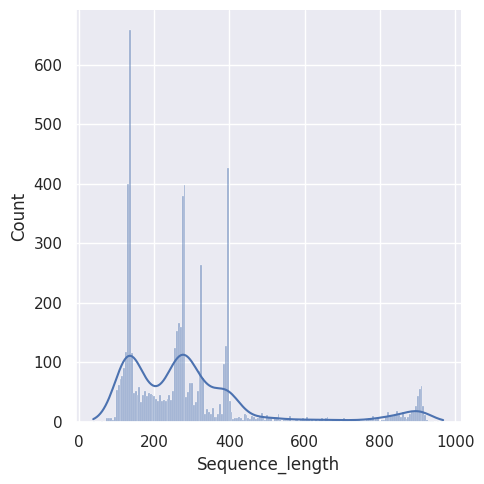

In [14]:
len_distro(f'output/{DATE}_1kp_cleaned.fasta')

In [15]:
size_filter(f'output/{DATE}_1kp_cleaned.fasta', '1kp', 'greater', 700)

Seqeunces from output/220712_1kp_cleaned.fasta were filtered to those greater than 700 aa
513 filtered sequences were outputed to "output/220712_1kp_size_filt.fasta"


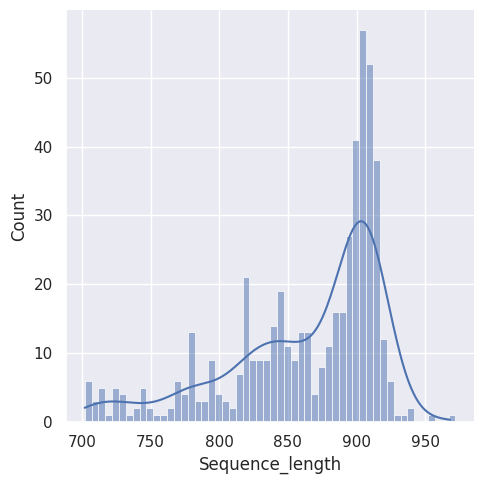

In [16]:
len_distro(f'output/{DATE}_1kp_size_filt.fasta')

[('MA', 254), ('VD', 31), ('EE', 15), ('DD', 12), ('VT', 10), ('DE', 9), ('DP', 8), ('ED', 6), ('RP', 6), ('VM', 5)]
The most common aa at n-terminal is "MA" and its freq. is: 
0.495


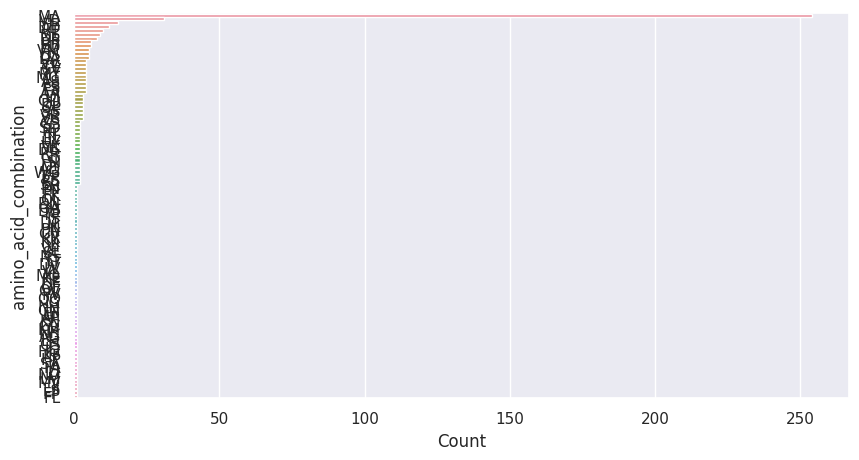

In [17]:
chart(f'output/{DATE}_1kp_size_filt.fasta', 2, 'n', 10, 5)

[('VF', 230), ('IF', 57), ('QF', 44), ('YD', 35), ('LF', 28), ('EF', 18), ('SF', 17), ('GY', 16), ('TF', 10), ('SL', 5)]
The most common aa at c-terminal is "VF" and its freq. is: 
0.448


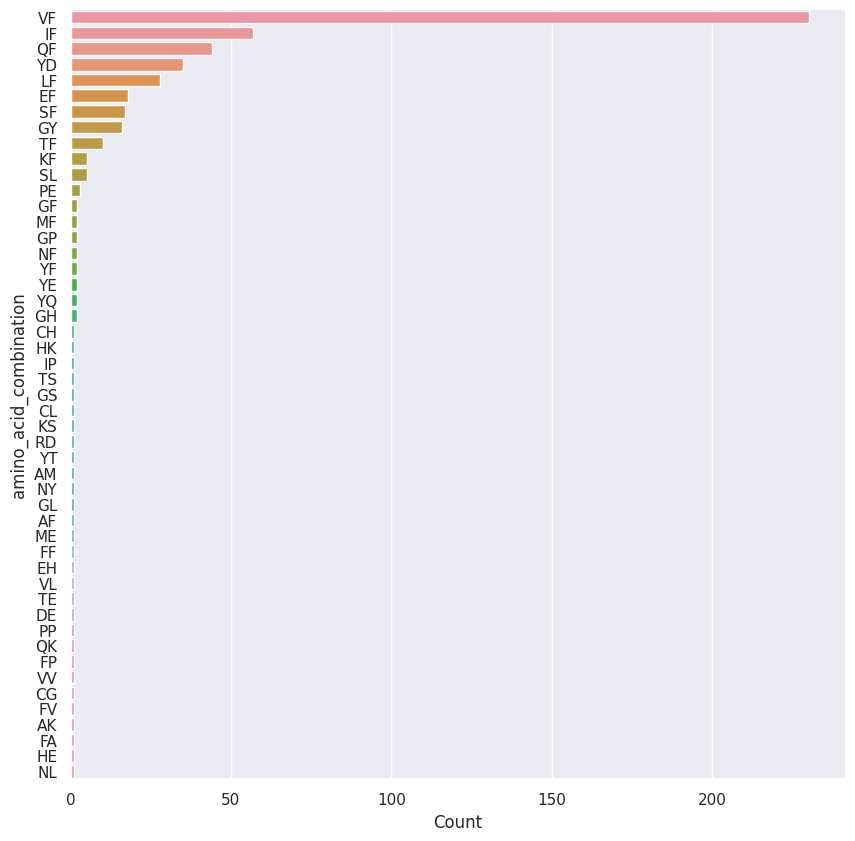

In [20]:
chart(f'output/{DATE}_1kp_size_filt.fasta', 2, 'c', 10, 10)

In [ ]:
#terminal_filter(f'output/220323_1kp_size_filt.fasta', '1kp', 'n', 'M')

In [ ]:
#terminal_filter(f'output/220323_NR_1kp_n-terminalCodon.fasta', '1kp', 'c', 'F', 'Y', 'L')

In [ ]:
#chart(f'output/220323_NR_1kp_c-terminalCodon.fasta', 1, 'c', 10, 5)

# Merge the fasta files from both data sources

When merging I need to make sure that if the species is found in phytozome that I remove the 1kp equiv

In [21]:
with open(f'output/{DATE}_NR_dataset.fasta', 'a+') as dataset:
    with open(f'output/{DATE}_1kp_size_filt.fasta', 'r') as onekp:
    #with open(f'output/{DATE}_NR_1kp_c-terminalCodon.fasta', 'r') as onekp:
        for line in onekp:
            dataset.write(line)
    with open(f'output/{DATE}_phyto_cleaned.fasta', 'r') as phyto:
    #with open(f'output/{DATE}_NR_phyto_c-terminalCodon.fasta', 'r') as phyto:
        for line in phyto:
            dataset.write(line)   

In [22]:
cleaner(f'output/{DATE}_NR_dataset.fasta', 'phyto_1kp')

972 were kept, output was written to 220712_phyto_1kp_cleaned.fasta. 0 sequences were dropped and written to output/220712_phyto_1kp_cleaner_dropped_seq.fasta
There were 0 instances of duplicate or ambiguous sequences.
output/220712_phyto_1kp_cleaned.fasta


No sequences were dropped from above so will use 211021_NR_dataset.fasta as the dataset

# Merge the index files

In [4]:
onekp = pd.read_csv("output/220712_NR_1kp_master_index.txt", sep = "\t")
phyto = pd.read_csv("output/211021_NR_phyto_master_index.csv")

onekp['Data_source'] = "1kp"
phyto['Data_source'] = "phyto"

In [5]:
onekp.head()

,Onekp_index_id,Seq_id,Subject Scientific Name,Subject Taxonomy ID,Percentage of identical matches,Alignment length,Number of mismatches,Number of gap openings,Start of alignment in query,End of alignment in query,...,Total number of gap,Expect value,Bit score,Phyto_species,Species,Description,Order,Scaffold_id,Sequence,Data_source
0,DLJZ,2059039,Solanum ptychanthum,45838,97.149,912,25,1,1,911,...,1,0,1854,NaN,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2059039,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSSKHELP...,1kp
1,DLJZ,2057353,Solanum ptychanthum,45838,31.552,393,225,12,109,481,...,44,0,206,NaN,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2057353,MPGIKGPSDYSREPPRHPCLKINSKEPFNAEPTRSALISSYVTPVD...,1kp
2,DLJZ,2054501,Solanum ptychanthum,45838,40.467,257,127,8,649,902,...,26,0,190,NaN,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2054501,MEFLERPDAQLIIGVAVAAVAVGATAYFYFSSKKSKVCLNPEEFRA...,1kp
3,DLJZ,2002023,Solanum ptychanthum,45838,34.752,282,144,7,615,890,...,40,0,154,NaN,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2002023,MAAFLRKLAKAAPVAFSEAFRGDSKSNFADPRFPFGAIAAVAGCVS...,1kp
4,DLJZ,2050677,Solanum ptychanthum,45838,46.250,80,42,1,532,610,...,1,0,84,NaN,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2050677,MPTLTKLFTMEEAAQHNTKDDCWVVIDGKVYDVSSYLDEHPGGDDV...,1kp


In [6]:
phyto.head()

,Protein,Short_species,Species,Phyto_species,Sequence,Scaffold_id,Description,Order,Data_source
0,Acora.12G059500,A_americanus,Acorus_americanus,Aamericanus_v1.1,MLGVRGPSDYTHEPPRHPCLRINAKEPFNAEPPRDALVSSFITPVD...,PHYT_3431815,Monocots/Commelinids,Acorales,phyto
1,Acora.11G193600,A_americanus,Acorus_americanus,Aamericanus_v1.1,MAASVDKRQFNHLEPPFTIFPSPPPQTFKDSSDSDSDSDPDHHEWK...,PHYT_2362616,Monocots/Commelinids,Acorales,phyto
2,Acora.03G182000,A_americanus,Acorus_americanus,Aamericanus_v1.1,MPGIRGPSDYSREPPRHPILQINAKAPFNAEPPRGALVSSFITPVD...,PHYT_3832029,Monocots/Commelinids,Acorales,phyto
3,Aqcoe6G016900,A_coerulea,Aquilegia_coerulea,Acoerulea_v3.1,MAASVQTRQFNGTDSQFRGGGCNFISTLEKKPVIQQKDYYYSSSED...,PHYT_1302463,Eudicots,Ranunculales,phyto
4,Aqcoe4G284100,A_coerulea,Aquilegia_coerulea,Acoerulea_v3.1,MAASVRSRQFNGTDSPFRGGGGGGVGGNFISTLPTKPPKDCYYSST...,PHYT_2618647,Eudicots,Ranunculales,phyto


In [7]:
# Print the lists of unique species and classifications in each of onekp and phyto datasets

onekp = onekp.loc[onekp["Description"] != "Outgroup"]

onekp_species = onekp['Species'].unique()
phyto_species = phyto['Species'].unique()

onekp_species = set(onekp_species)
phyto_species = set(phyto_species)

unique_sp_onekp = onekp_species - phyto_species
unique_sp_phyto = phyto_species - onekp_species

print(f"Species unique to 1kp dataset:\n{unique_sp_onekp}\n")
print(f"Species unique to phyto dataset:\n{unique_sp_phyto}\n")

onekp_tax = onekp['Description'].unique()
phyto_tax = phyto['Description'].unique()

onekp_tax = set(onekp_tax)
phyto_tax = set(phyto_tax)

unique_cl_onekp = onekp_tax - phyto_tax
unique_cl_phyto = phyto_tax - onekp_tax

print("\n")
print(f"Classificaitons unique to 1kp dataset:\n{unique_cl_onekp}\n")
print(f"Classificaitons unique to phyto dataset:\n{unique_cl_phyto}\n")


Species unique to 1kp dataset:
{'Anemia_tomentosa', 'Asplenium_platyneuron', 'Catharanthus_roseus', 'Alsophila_pinulosa', 'Serenoa_repens', 'Bacopa_caroliniana', 'Cyanastrum_cordifolium', 'Ipomoea_coccinea', 'Thalictrum_thalictroides', 'Illicium_floridanum', 'Cercis_canadensis', 'Aristida_stricta', 'Polanisia_trachysperma', 'Cryptogramma_acrostichoides', 'Sabal_bermudana', 'Cochlearia_officinalis', 'Ilex_sp.', 'Ludovia_sp.', 'Cyperus_papyrus', 'Salix_dasyclados', 'Scaevola_mossambicensis', 'Polypremum_procumbens', 'Marattia_attenuata', 'Pistia_stratiotes', 'Paulownia_fargesii', 'Galium_boreale', 'Plantago_maritima', 'Larrea_tridentata', 'Francoa_appendiculata', 'Quillaja_saponaria', 'Acacia_argyrophylla', 'Holarrhena_pubescens', 'Isoetes_sp.', 'Santalum_acuminatum', 'Tropaeolum_peregrinum', 'Peltoboykinia_watanabei', 'Pinus_ponderosa', 'unknown', 'Torreya_taxifolia', 'Ajuga_reptans', 'Oncidium_sphacelatum', 'Peperomia_fraseri', 'Myrica_cerifera', 'Racomitrium_elongatum', 'Glycyrrhiza_l

In [8]:
joint = onekp.merge(phyto, on=['Species', 'Order', 'Description', 'Sequence', 'Scaffold_id', 'Data_source'], how='outer')

In [9]:
joint.to_csv(f"output/{DATE}_master_index.csv", index = False)

In [11]:
# Create a fasta file from the master_index.csv

master_df = pd.read_csv(f'output/220712_master_index.csv')

temp_df = master_df

temp_df['Header'] = master_df['Scaffold_id'] + '|' + master_df['Species'] + '|' + master_df['Description'] + '|' + master_df['Order']+ '|' + master_df['Data_source'] 

master_dict = dict(zip(temp_df['Header'], temp_df['Sequence']))

with open(f'output/{DATE}_phyto_1kp_master.fasta', 'w') as form: # Creates a fasta file with informative header
                                                                # for use going forward
    for k,v in master_dict.items(): 
        form.write('>' + k + '\n' + v +'\n')

In [12]:
temp_df

,Onekp_index_id,Seq_id,Subject Scientific Name,Subject Taxonomy ID,Percentage of identical matches,Alignment length,Number of mismatches,Number of gap openings,Start of alignment in query,End of alignment in query,...,Species,Description,Order,Scaffold_id,Sequence,Data_source,Protein,Short_species,Phyto_species_y,Header
0,DLJZ,2059039.0,Solanum ptychanthum,45838.0,97.149,912.0,25.0,1.0,1.0,911.0,...,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2059039,MAASVENRQFSHLEPGLSGVGRTFKPRSDSPVRGCNFPPSSKHELP...,1kp,NaN,NaN,NaN,DLJZ_2059039|Solanum_ptychanthum|Core_eudicots...
1,DLJZ,2057353.0,Solanum ptychanthum,45838.0,31.552,393.0,225.0,12.0,109.0,481.0,...,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2057353,MPGIKGPSDYSREPPRHPCLKINSKEPFNAEPTRSALISSYVTPVD...,1kp,NaN,NaN,NaN,DLJZ_2057353|Solanum_ptychanthum|Core_eudicots...
2,DLJZ,2054501.0,Solanum ptychanthum,45838.0,40.467,257.0,127.0,8.0,649.0,902.0,...,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2054501,MEFLERPDAQLIIGVAVAAVAVGATAYFYFSSKKSKVCLNPEEFRA...,1kp,NaN,NaN,NaN,DLJZ_2054501|Solanum_ptychanthum|Core_eudicots...
3,DLJZ,2002023.0,Solanum ptychanthum,45838.0,34.752,282.0,144.0,7.0,615.0,890.0,...,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2002023,MAAFLRKLAKAAPVAFSEAFRGDSKSNFADPRFPFGAIAAVAGCVS...,1kp,NaN,NaN,NaN,DLJZ_2002023|Solanum_ptychanthum|Core_eudicots...
4,DLJZ,2050677.0,Solanum ptychanthum,45838.0,46.250,80.0,42.0,1.0,532.0,610.0,...,Solanum_ptychanthum,Core_eudicots/Asterids,Solanales,DLJZ_2050677,MPTLTKLFTMEEAAQHNTKDDCWVVIDGKVYDVSSYLDEHPGGDDV...,1kp,NaN,NaN,NaN,DLJZ_2050677|Solanum_ptychanthum|Core_eudicots...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zea_mays,Monocots/Commelinids,Poales,PHYT_2731697,MAAVEPRQFGRLEPARVGAYPPPPSHIPRRADSPARGCGFPPLVSP...,phyto,Zm00001d031769,Z_mays,Zmays_RefGen_V4,PHYT_2731697|Zea_mays|Monocots/Commelinids|Poa...
7038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zea_mays,Monocots/Commelinids,Poales,PHYT_6862052,MAASVERHLAPHPWPANAPPKSFDMFRTGSDSDSEDEDSIPAVDWR...,phyto,Zm00001d052139,Z_mays,Zmays_RefGen_V4,PHYT_6862052|Zea_mays|Monocots/Commelinids|Poa...
7039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zea_mays,Monocots/Commelinids,Poales,PHYT_2065661,MAAVEPRQFGRLEPGSSPVRVATNGAKAYPPPASHLPRRADSPVRG...,phyto,Zm00001d049995,Z_mays,Zmays_RefGen_V4,PHYT_2065661|Zea_mays|Monocots/Commelinids|Poa...
7040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Zea_mays,Monocots/Commelinids,Poales,PHYT_7245880,MAASVERHLAPHPWPANAPPKSFDMFRSGGPGGKRRTGPDSDSEDE...,phyto,Zm00001d018206,Z_mays,Zmays_RefGen_V4,PHYT_7245880|Zea_mays|Monocots/Commelinids|Poa...


In [21]:
# Print the A. thaliana headers
temp_df2 = temp_df.loc[temp_df['Species'] == "Arabidopsis_thaliana"]
temp_df2 = temp_df2['Header']
temp_df2.iloc[0]

'PHYT_6642896|Arabidopsis_thaliana|Core_eudicots/Rosids|Brassicales|phyto'

In [22]:
temp_df2.iloc[1]

'PHYT_1421262|Arabidopsis_thaliana|Core_eudicots/Rosids|Brassicales|phyto'

In [23]:
temp_df2.iloc[2]

'PHYT_5350191|Arabidopsis_thaliana|Core_eudicots/Rosids|Brassicales|phyto'

# Remove overly similar sequences

In [4]:
# Run T-COFFEE reformat utility to remove overly similary sequences, keeping the A. thaliana ones
os.system(f"t_coffee -other_pg seq_reformat -in output/{DATE}_phyto_1kp_master.fasta -action +trim _seq_%80_fNAME Arabidopsis_thaliana -output fasta_seq >output/BLAST/{DATE}_sequences_for_blast.fasta")


!		[Similarity Matrix Computation: ][TOT=24728028][  2 %][REMAINING TIME: 24794 sec.]

# Create SSN using BLAST

In [ ]:
# Change fasta headers to only have Scaffold_id for blast network generation

with open(f"output/{DATE}_sequences_for_SSN.fasta", "w") as blast_fasta:

    for seq_record in SeqIO.parse(f"output/BLAST/{DATE}_sequences_for_blast.fasta", "fasta"):
        seq_id = seq_record.id
        id_lst = seq_id.split("|")
        scaffold_id = id_lst[0]

        sequence = seq_record.seq

        blast_fasta.write(f">{scaffold_id}\n")
        blast_fasta.write(f"{sequence}\n")

In [2]:
# Run a all v all BLAST search using a blast function 
# BLAST must be installed locally.
# Takes 3 arguments, a fasta file, the project name, and the e-value threshold.

# Just a clear way of laying out the function arguments

in_fasta = f'output/220712_sequences_for_SSN.fasta' # Use the last outputted 
                                                        # fasta file from above
# path = '/usr/lib/ncbi-blast-2.12.0+/bin'

# Actual BLAST function, using default E_value_threshold="10e-10", cpus="2" (adjust 
# these arguments as required)

blast(in_fasta, '10e-10', cpus='24')



Building a new DB, current time: 07/13/2022 08:56:19
New DB name:   /home/mattm/projects/PR/output/BLAST/220713_dataset_db
New DB title:  output/220712_sequences_for_SSN.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /home/mattm/projects/PR/output/BLAST/220713_dataset_db
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 6711 sequences in 0.0852249 seconds.


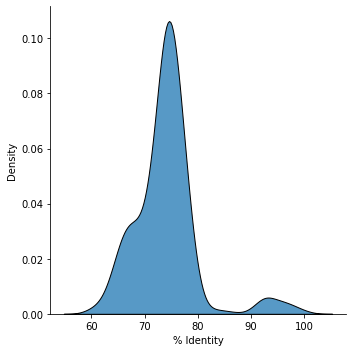

In [ ]:
blast_table = pd.read_csv("output/BLAST/220323_dataset_network_10e-10.csv")

per_id = blast_table[["Query", '% Identity']]
Athaliana = per_id.loc[per_id['Query'] == 'PHYT_1421262'] 

sns.displot(Athaliana, x = '% Identity', kind = 'kde', multiple = 'stack')

In [ ]:
# Run a all v all BLAST search using a blast function 
# BLAST must be installed locally.
# Takes 3 arguments, a fasta file, the project name, and the e-value threshold.

# Just a clear way of laying out the function arguments

blast_path = '/Users/u6280883/Library/ncbi-blast-2.12.0+/bin/' # Only needed if blast hasn't been 
                                                      # added to the PATH environment, must 
                                                      # end in '/'
in_fasta = f'output/220323_sequences_to_blast.fasta' # Use the last outputted 
                                                        # fasta file from above
# path = '/usr/lib/ncbi-blast-2.12.0+/bin'

# Actual BLAST function, using default E_value_threshold="10e-10", cpus="2" (adjust 
# these arguments as required)

blast(in_fasta, '10e-10', cpus='6', path=blast_path)



Building a new DB, current time: 03/23/2022 15:50:33
New DB name:   /Users/u6280883/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Documents/Main/Uni/2.PhD/3.NR/NR_python_pipeline/output/BLAST/220323_dataset_db
New DB title:  output/220323_sequences_to_blast.fasta
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/u6280883/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Documents/Main/Uni/2.PhD/3.NR/NR_python_pipeline/output/BLAST/220323_dataset_db
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 541 sequences in 0.0245349 seconds.


Run time: 0:02:30 hh:mm:ss
Network file output/BLAST/220323_dataset_network_10e-10.csv generated


# Run Evolocity